In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from src.helpers import (letter_subplots)

sns.set(context='paper', 
        style='ticks',
        font_scale=1.2, 
        palette='colorblind',
        # font='serif',
        )

/opt/homebrew/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 1. Data Preprocessing

In [2]:
epochs = 30 # data partition (important for the dataset construction)

In [3]:
df = pd.read_csv('../data/words_translations.csv')
df.shape

(54314, 10)

In [4]:
df['word_id'].nunique()

9077

In [5]:
df = (df.
      pipe(lambda df: df[~df['rating'].isna()]). # rating is not null
      pipe(lambda df: df[df['rating'] >= 0]). # rating is higher or equal to 0
      pipe(lambda df: df.assign(translation_created_at=pd.to_datetime(df['translation_created_at']))). # assign translation creation time
      pipe(lambda df: df.assign(word_created_at=pd.to_datetime(df['word_created_at']))). # assign word creation time
      # create 100 bins (pd.date_rae(start=df['translation_created_at'].min(), end=df['translation_created_at'].max(), periods=epochs))
      pipe(lambda df: df.assign(bin=pd.cut(df['translation_created_at'], bins=epochs, labels=range(epochs)))). # cut into 30 bins
      pipe(lambda df: df[~df['bin'].isna()]). # check that the bin variable is not na
      pipe(lambda df: df.assign(word_n_words=df['word_body'].str.split().str.len())). # 
      pipe(lambda df: df[df['word_n_words'] == 1]).
      pipe(lambda df: df.assign(translation_n_words=df['translation_body'].str.split().str.len())).
      # only keep translations with 1 word
      pipe(lambda df: df[df['translation_n_words'] == 1]).
      # compute lengths in characters for each translation
      pipe(lambda df: df.assign(translation_len=df['translation_body'].str.len())).
      pipe(lambda df: df.assign(word_len=df['word_body'].str.len())).
      pipe(lambda df: df[df['translation_len'] > 1]).
      pipe(lambda df: df[df['word_len'] > 1])
).dropna()

In [6]:
# save as cleaned
df.to_csv('../data/words_translations_cleaned.csv', index=False)

In [7]:
(df['translation_created_at'].max() - df['translation_created_at'].min()).days / 365

9.131506849315068

In [8]:
(df['translation_created_at'].max() - df['translation_created_at'].min())/30

Timedelta('111 days 03:08:07.171878834')

In [9]:
df['translation_created_at'].min()

Timestamp('2014-04-29 15:22:24.301251')

In [10]:
df['translation_created_at'].max()

Timestamp('2023-06-15 13:25:59.457616')

In [11]:
df['rating'].sum()

130394.0

In [12]:
votes = pd.read_csv("../data/votes.csv")
votes['created_at'] = pd.to_datetime(votes['created_at'])
# votes['bin'] = pd.cut(votes['created_at'], bins=epochs, labels=range(epochs))
# use datettime from df to create identical bins ('translation_created_at') and label then with range(epochs)
votes['bin'] = pd.cut(votes['created_at'], bins=pd.date_range(start=df['translation_created_at'].min(), 
                                                              end=df['translation_created_at'].max(), 
                                                              periods=epochs+1), labels=range(epochs))
votes = votes[~votes['bin'].isna()]

In [34]:
# count cumulative number of users per bin and store in a list
cumulative_users = []

for i in range(epochs):
    cumulative_users.append(votes[votes['bin'] <= i]['user_id'].nunique())

In [13]:
# votes should have the same translations as df
votes = votes[votes['translation_id'].isin(df['translation_id'])]
print(votes['user_id'].unique().shape[0])
# group by bin and user and count the number of votes
votes_ = votes.groupby(['bin', 'user_id']).size().reset_index(name='votes')
# for each bin, get the list of values in the column 'votes'
votes_ = votes_.query('votes > 0')
votes_ = votes_.groupby('bin')['votes'].apply(list).reset_index(name='votes')

4700


In [14]:
# Initialize a set to track seen word_ids
seen_word_ids = set()

# Create a new column to count truly unique words per bin
df['truly_unique_words'] = 0

# Iterate through the bins in order
for bin_name in sorted(df['bin'].unique()):
    # Get the rows corresponding to the current bin
    current_bin = df[df['bin'] == bin_name]
    
    # Identify new unique words in this bin
    new_unique_words = set(current_bin['word_id']) - seen_word_ids
    
    # Update the seen_word_ids set
    seen_word_ids.update(new_unique_words)
    
    # Count the truly unique words for this bin
    df.loc[df['bin'] == bin_name, 'truly_unique_words'] = len(new_unique_words)

# Now aggregate to get the desired DataFrame
df_unique = df.groupby('bin').agg({
    'truly_unique_words': 'max', 
    'translation_id': 'nunique'
}).reset_index()

df_unique.columns = ['bin', 'n_words', 'n_translations']

In [15]:
df_unique['n_words'].sum()

7606

In [16]:
votes_ = votes_.set_index('bin')['votes'].to_dict()
n_words = df_unique['n_words'].to_numpy().round().astype(int)
n_translations = df_unique['n_translations'].to_numpy().astype(int)
translation_len = df['translation_len'].to_numpy().astype(int)

In [17]:
with open('../data/n_words.pkl', 'wb') as f:
    pickle.dump(n_words, f)

with open('../data/n_translations.pkl', 'wb') as f:
    pickle.dump(n_translations, f)

with open('../data/votes.pkl', 'wb') as f:
    pickle.dump(votes_, f)

with open('../data/translation_len.pkl', 'wb') as f:
    pickle.dump(translation_len, f)

In [18]:
n_translations.sum()

42044

In [19]:
n_words.sum()

7606

In [20]:
df['word_id'].nunique()

7606

In [21]:
df['translation_id'].nunique()

42044

In [22]:
df['translation_id'].nunique() / df['word_id'].nunique()

5.527741256902446

In [23]:
# true_likes = df['rating'].to_numpy()
true_likes = votes.groupby('translation_id').count()['id'].values
true_ranked = np.argsort(true_likes)[::-1]
true_likes = true_likes[true_ranked]

In [24]:
true_likes.sum()

129974

In [25]:
# add zeros so that the length of true_likes is (number of unique translations)
true_likes = np.concatenate([true_likes, np.zeros(df_unique['n_translations'].sum() - len(true_likes))])
true_likes.shape

(42044,)

In [26]:
# dump true_likes
with open('../data/true_likes.pkl', 'wb') as f:
    pickle.dump(true_likes, f)

In [27]:
# in df, for each word_if find the word with the maximum rating
# true_len_likes = df.sort_values('rating', ascending=False).drop_duplicates('word_id')[['translation_len', 'rating']].values
# just get the rating and lengths for every translation
true_len_likes = df[['translation_len', 'rating']].values
# sort by number of likes
true_len_likes = true_len_likes[np.argsort(true_len_likes[:, 1])[::-1]]
true_len_likes.shape

(42044, 2)

In [28]:
# dump true_likes
with open('../data/true_len_likes.pkl', 'wb') as f:
    pickle.dump(true_len_likes, f)

In [29]:
votes_count = np.array([sum(v) for v in votes_.values()])

### 2. Summary figure

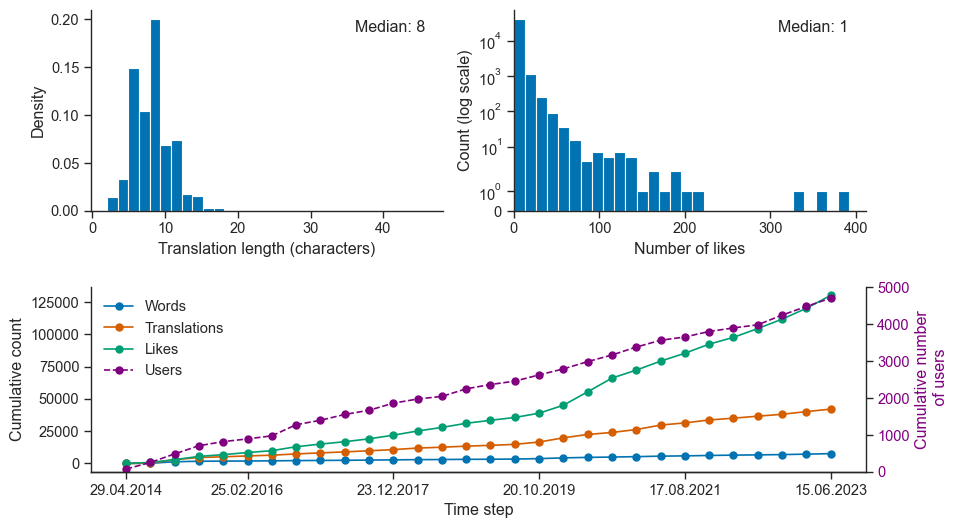

In [ ]:
# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1], 'hspace': 0.3})

# First subplot: Histogram of translation lengths
axs[0, 0].hist(translation_len, bins=30, density=True)
axs[0, 0].text(0.95, 0.95, f'Median: {np.median(translation_len):.0f}', 
               horizontalalignment='right', verticalalignment='top', transform=axs[0, 0].transAxes)
axs[0, 0].set_xlabel('Translation length (characters)')
axs[0, 0].set_ylabel('Density')
sns.despine(ax=axs[0, 0])

# Second subplot: Histogram of likes with log-scale y-axis
axs[0, 1].hist(true_likes, bins=30)
axs[0, 1].set_yscale('symlog', base=10)
axs[0, 1].text(0.95, 0.95, f'Median: {np.median(true_likes):.0f}', 
               horizontalalignment='right', verticalalignment='top', transform=axs[0, 1].transAxes)
sns.despine(ax=axs[0, 1])
axs[0, 1].set_xlabel('Number of likes')
axs[0, 1].set_ylabel('Count (log scale)')
axs[0, 1].set_xlim(0, None)

# Remove bottom left and right subplots
axs[1, 0].axis('off')
axs[1, 1].axis('off')

# Reduce space between top and bottom plots
plt.subplots_adjust(hspace=0.5)

# Third subplot: Cumulative plots spanning the bottom row
ax_bottom = fig.add_subplot(212)  # Use the entire bottom row

# Plot cumulative counts
ax_bottom.plot(df_unique['bin'], df_unique['n_words'].cumsum(), label='Words', marker='o', markersize=5, color='b', alpha=1)
ax_bottom.plot(df_unique['bin'], df_unique['n_translations'].cumsum(), label='Translations', marker='o', markersize=5, color='r', alpha=1)
ax_bottom.plot(df_unique['bin'], votes_count.cumsum(), label='Likes', marker='o', markersize=5, color='g', alpha=1)

# Secondary y-axis for cumulative users
ax_users = ax_bottom.twinx()
ax_users.plot(range(epochs), cumulative_users, marker='o', markersize=5, color='purple', alpha=1, linestyle='dashed', label='Users')

# Labels and Ticks
ax_bottom.set_xlabel('Time step')
ax_bottom.set_ylabel('Cumulative count')
ax_users.set_ylabel('Cumulative number\n of users', color='purple')
# limit right y axis to 5000
ax_users.set_ylim(0, 5000)
ax_users.tick_params(axis='y', labelcolor='purple')

# Adjust x-ticks and labels
ax_bottom.set_xticks(sorted([0] + list(range(29, 0, -6))))
labels = pd.date_range(start=df['translation_created_at'].min(), 
                       end=df['translation_created_at'].max(), 
                       periods=len(ax_bottom.get_xticks())).strftime('%d.%m.%Y')
ax_bottom.set_xticklabels(labels, rotation=0, ha='center')

# Handle legends from both axes
lines_bottom, labels_bottom = ax_bottom.get_legend_handles_labels()
lines_users, labels_users = ax_users.get_legend_handles_labels()
ax_bottom.legend(lines_bottom + lines_users, labels_bottom + labels_users, frameon=False, loc='upper left')

sns.despine(ax=ax_bottom, right=False)  # Keep right spine for secondary axis
sns.despine(ax=ax_users, left=True) 

# Adjust layout to make space for the bottom plot
# plt.tight_layout()
plt.savefig('../figures/Figure_1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()